<a href="https://colab.research.google.com/github/LillyMac12/ACGWEP/blob/main/Inference_GW150914.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install pycbc and sampler version

import sys
!{sys.executable} -m pip install pycbc ligo-common emcee==2.2.1 --no-cache-dir

In [2]:
# Data download from gwosc, highpass+resample data as well

from pycbc.catalog import Merger
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.frame import read_frame
from pycbc.filter import highpass, resample_to_delta_t
from astropy.utils.data import download_file

m = Merger("GW150914")

ifos = ['H1',
        'L1',
       ]

data_filenames = {}

psds = {}
data = {}

for ifo in ifos:
    print("Processing {} data".format(ifo))

    # Download the gravitational wave data for GW150914
    url = "https://gwosc.org/eventapi/html/GWTC-1-confident/GW150914/v3/{}-{}1_GWOSC_4KHZ_R1-1126257415-4096.gwf"
    fname = download_file(url.format(ifo[0], ifo[0]), cache=True)
    data_filenames[ifo] = fname

    # Read the gravitational wave data and do some minimal
    # conditioning of the data.
    ts = read_frame(fname, "{}:GWOSC-4KHZ_R1_STRAIN".format(ifo),
                    start_time=int(m.time - 260),
                    end_time=int(m.time + 40))
    ts = highpass(ts, 15.0)                     # Remove low frequency content
    ts = resample_to_delta_t(ts, 1.0/2048)      # Resample data to 2048 Hz
    ts = ts.time_slice(m.time-112, m.time + 16) # Trim
    data[ifo] = ts.to_frequencyseries()         # FFT

    # PSD
    psd = interpolate(ts.psd(4), ts.delta_f)
    psd = inverse_spectrum_truncation(psd, int(4 * psd.sample_rate),
                                      trunc_method='hann',
                                      low_frequency_cutoff=20.0)
    psds[ifo] = psd


/usr/local/lib/python3.11/dist-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


Processing H1 data
Processing L1 data


In [62]:
# Set static and variable parameters (ones you want to find)

from pycbc.inference import models, sampler
from pycbc.distributions import Uniform, JointDistribution, SinAngle
import numpy

static = {'mass1':25,
          'mass2':25,
          'f_lower':30.0,
          'approximant':"IMRPhenomXPHM",
          'polarization':0,
          'ra': 3.44615914,
          'dec': -0.40808407
         }

variable = ('distance',
            'inclination',
            'tc')

# Set variable priors

inclination_prior = SinAngle(inclination=None)
distance_prior = Uniform(distance=(200, 700))
tc_prior = Uniform(tc=(m.time-0.1, m.time+0.1))

prior = JointDistribution(
    variable, inclination_prior, distance_prior, tc_prior)

In [64]:
# Set up sampling model (MCMC normally)

import copy
model = models.SingleTemplate(variable, copy.deepcopy(data),
                              low_frequency_cutoff={'H1':30, 'L1':30},
                              psds = psds,
                              static_params = static,
                              prior = prior,
                              sample_rate = 8192,
                              )

# Set up sampler, how many walkers, temp, etc.

smpl = sampler.EmceePTSampler(model, 5, 300, nprocesses=8)
_ = smpl.set_p0() # Set p0 (if its not it will use the models prior to draw initial points)

In [65]:
# Takes forever to run depending on how many walkers and samples, 5-20 minutes ish

smpl.run_mcmc(400)

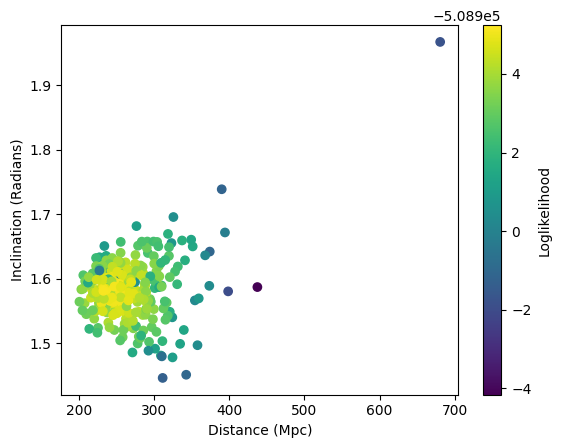

In [81]:
# Plot scatter if infering 2 params

import pylab, numpy

lik = smpl.model_stats['loglikelihood']
s = smpl.samples

# Access the arrays differently, there's an additional dimension

pylab.scatter(s['distance'][0,:,-1],
              s['inclination'][0,:,-1],
              c=lik[0,:,-1])
pylab.xlabel('Distance (Mpc)')
pylab.ylabel('Inclination (Radians)')

c = pylab.colorbar()
c.set_label('Loglikelihood')
pylab.show()

Text(0.5, 1.0, 'Distance Posterior GW150914')

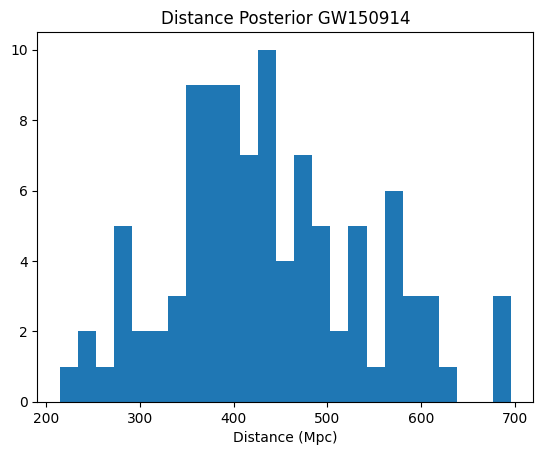

In [80]:
# Posterior plot for 1 param (distance)

_ = pylab.hist(s['distance'][0,:100,20].flatten(), bins=25)
pylab.xlabel("Distance (Mpc)")
pylab.title("Distance Posterior GW150914")